8449586


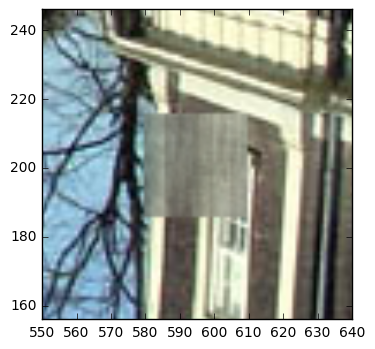

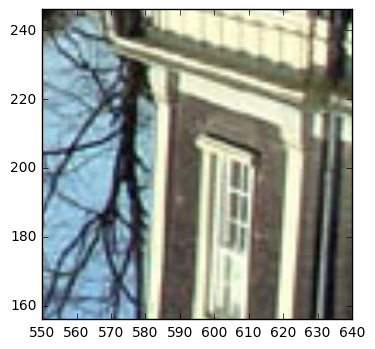

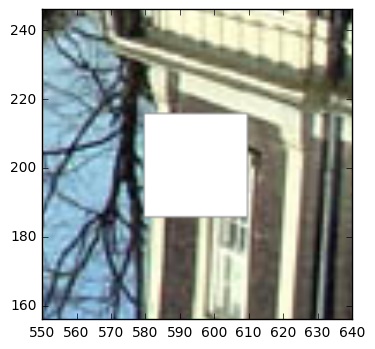

2905653


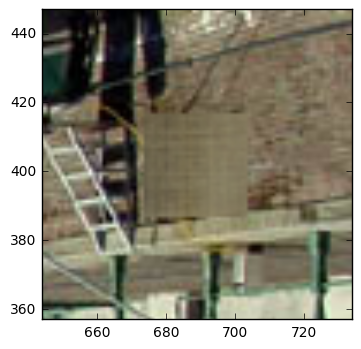

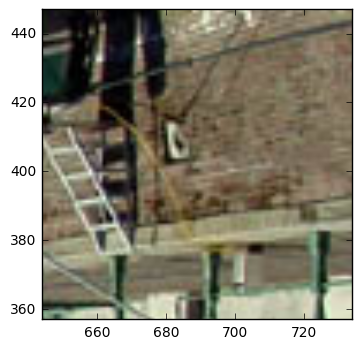

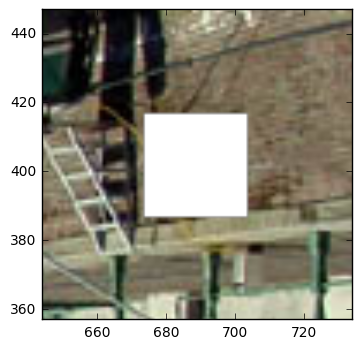

537841


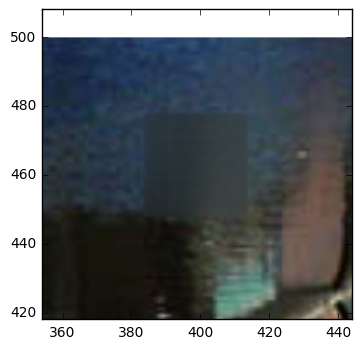

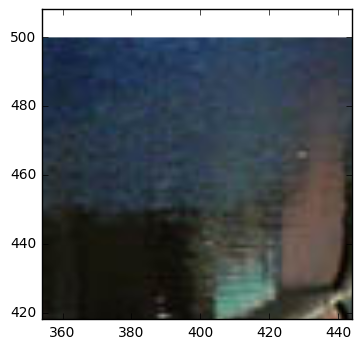

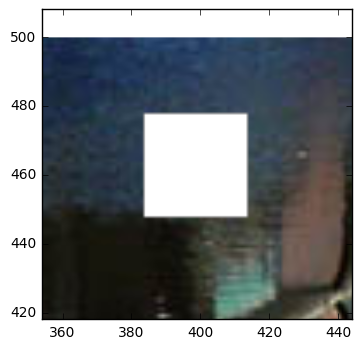

14163


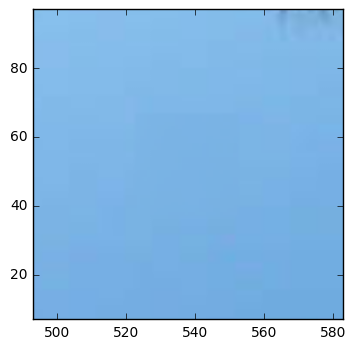

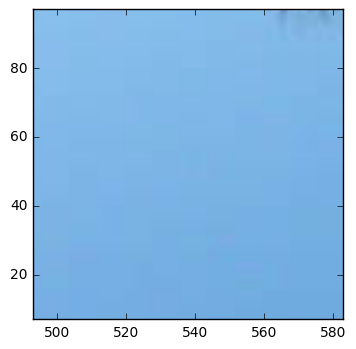

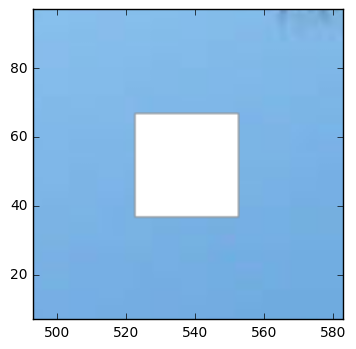

1117103


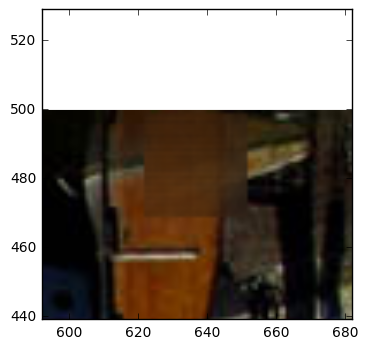

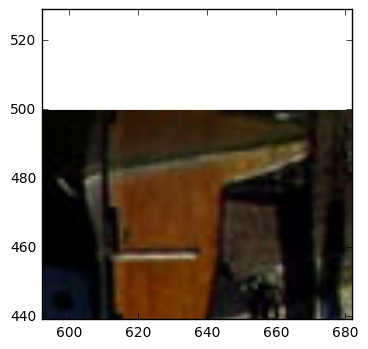

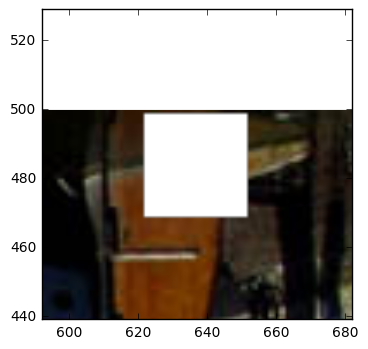

928483


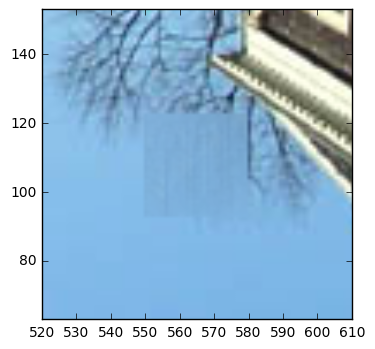

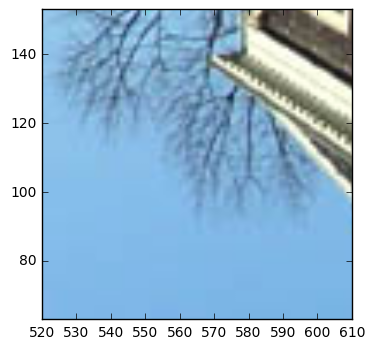

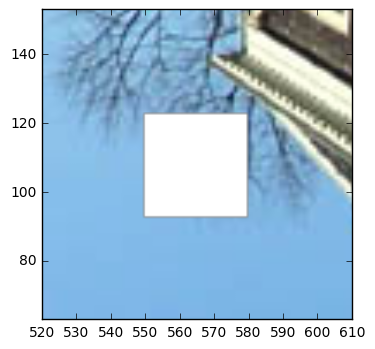

13262008


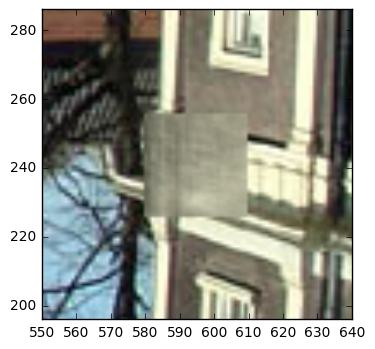

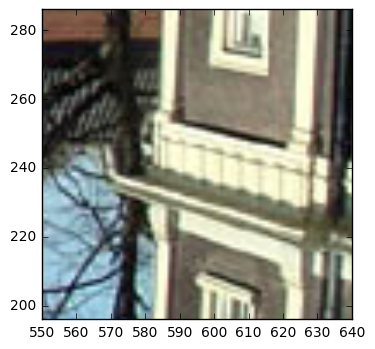

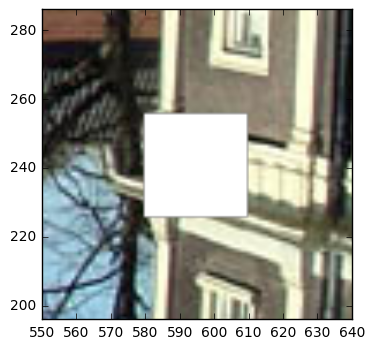

9261866


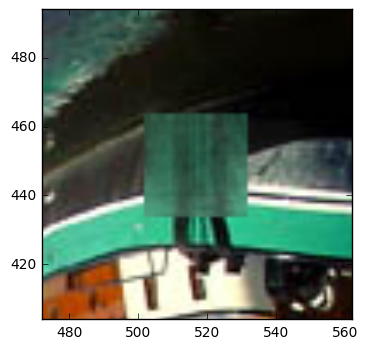

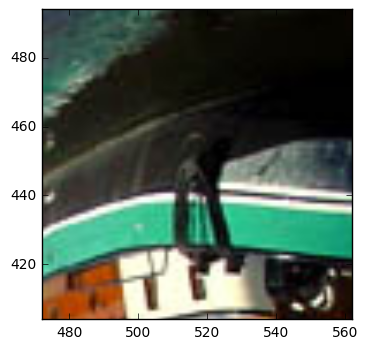

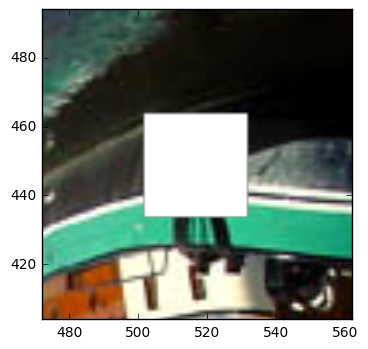

1135628


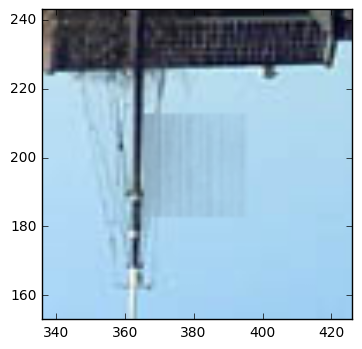

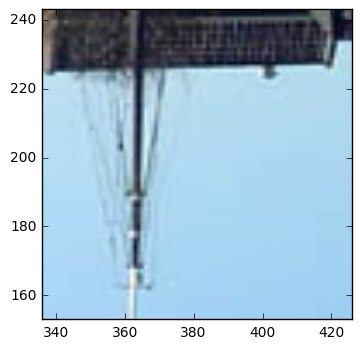

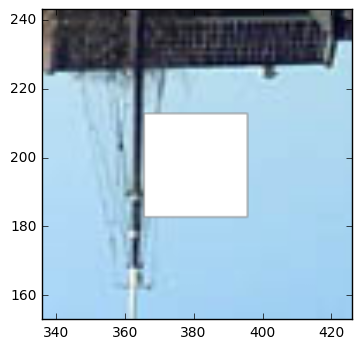

3566933


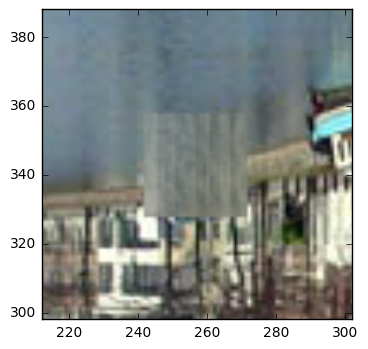

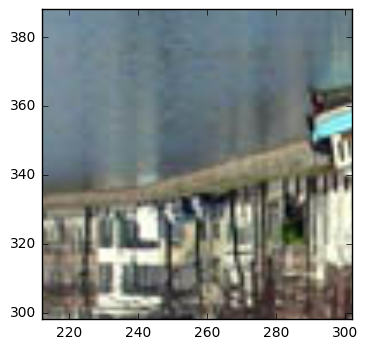

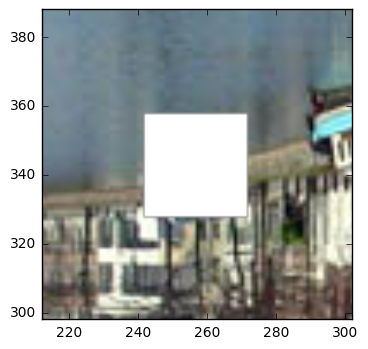

In [1]:
%matplotlib inline

import random
import operator
import matplotlib.pyplot as plt
import math
import numpy as np
import os

import netCDF4
import pylab
import matplotlib.pyplot as plt
from PIL import Image

from deap import base, creator, gp, tools

class Imager(object):
    def __init__(self, srcimage):
        self.srcimage = srcimage
        
    def ImageGetMaxXY(self):
        img = Image.open(self.srcimage)
        (self.xMax, self.yMax) = img.size
        img.close()
        
    def PunchHole(self, x, y, dx, dy):
        self.imghole = Image.open(self.srcimage).copy().convert('RGBA')
        self.imgholePA = self.imghole.load()
        self.xHole = x
        self.yHole = y
        (self.xMax, self.yMax) = self.imghole.size
        self.dx = dx
        self.dy = dy
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                if self.imgholePA[x, y] != (255, 255, 255, 255):
                    self.imgholePA[x, y] = (0, 0, 0, 0)
        self.imghole.save(self.srcimage.replace(r'.png', r'_hole.png'))

    def FindPixelInDirection(self, x, y, rx, ry):
        if rx == 0 and ry == 0:
            return None
        found = False
        cx = x
        cy = y
        while not found:
            cx += rx
            cy += ry
            if cx < 0 or cx >= self.xMax:
                break
            if cy < 0 or cy >= self.yMax:
                break
            pixel = self.imgholePA[cx, cy]
            if pixel != (255, 255, 255, 255) and pixel != (0, 0, 0, 0):
                found = True
        return pixel if found else None
    
    def ApplyIndividual(self, lst, dstimage):
        self.workimage = self.imghole.copy()
        self.workimagePA = self.workimage.load()
        pixels = list(lst)
        numPairs = len(pixels) / 2
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                nr = 0
                ng = 0
                nb = 0
                pixelsFound = 0
                if self.imgholePA[x,y] == (0, 0, 0, 0):
                    for i in range(0, numPairs):
                        rx = pixels[2 * i]
                        ry = pixels[2 * i + 1]
                        newPixel = self.FindPixelInDirection(x, y, rx, ry)
                        if newPixel != None:
                            pixelsFound += 1
                            nr += newPixel[0]
                            ng += newPixel[1]
                            nb += newPixel[2]
#                             print nr
#                             print ng
#                             print nb
#                             print numPairs
                    if pixelsFound > 0:
                        self.workimagePA[x, y] = (nr / numPairs, ng / numPairs, nb / numPairs, 255)
                    else:
                        print r'no pixels found!'
        self.workimage.save(dstimage)
        self.workimage.close() 
    
    def EvaluateIndividual(self, dstimage):
        refimg = Image.open(self.srcimage)
        refimgPA = refimg.load()
        cmpimg = Image.open(dstimage)
        cmpimgPA = cmpimg.load()
        
        score = 0
        for x in range(self.xHole, self.xHole + self.dx):
            for y in range(self.yHole, self.yHole + self.dy):
                if self.imgholePA[x, y] != (255, 255, 255, 255):
                    s = refimgPA[x, y]
                    c = cmpimgPA[x, y]
                    score += pow(abs(s[0] - c[0]), 2) + \
                             pow(abs(s[1] - c[1]), 2) + \
                             pow(abs(s[2] - c[2]), 2)
        refimg.close()
        cmpimg.close()
        return score
    
    def DisplayFilledRegion(self, dstimage):
        img = Image.open(dstimage)
        plt.imshow(np.asarray(img))
        plt.xlim(self.xHole - self.dx, self.xHole + self.dx * 2)
        plt.ylim(self.yHole - self.dy, self.yHole + self.dy * 2)
        plt.show()
        img.close()    

    def DisplayReference(self):
        img = Image.open(self.srcimage)
        plt.imshow(np.asarray(img))
        plt.xlim(self.xHole - self.dx, self.xHole + self.dx * 2)
        plt.ylim(self.yHole - self.dy, self.yHole + self.dy * 2)
        plt.show()
        img.close()

    def DisplayHole(self):
        plt.imshow(np.asarray(self.imghole))
        plt.xlim(self.xHole - self.dx, self.xHole + self.dx * 2)
        plt.ylim(self.yHole - self.dy, self.yHole + self.dy * 2)
        plt.show()

    def wrapup(self):
        self.imghole.close()

# Evaluate best individual
i = Imager('schiedam.png') #eco.png')
i.ImageGetMaxXY()
holeSizeX = 30
holeSizeY = 30
#topper = [-4, 0, -2, 3, -4, 5, -4, 1, -5, 4, -2, 2, 1, 0, -1, 1, 1, 0, -3, 0, -5, 1, -2, 1, -3, 1, -1, 0, -4, 1, -5, 4, -2, 3, -1, 1, -4, 3, -1, 1, -4, 3, -4, 3, -4, 3, -3, 2, -3, 1, 1, 0, 5, 3, -4, 3, -3, 0, -2, 1, -5, 1, -3, 2, 1, 0, 5, 5, -5, 1, 0, 0, -2, 1, -2, 2, -2, 3, -3, 2, -5, 1, -2, 1, 0, 0, 1, 0, -3, 2, -5, 1, -1, 1, -3, 3, -1, 0, 1, 0] # eco
topper = [0, -1, 2, -4, 1, 1, -1, -9, 9, 2, 8, 6, -2, -6, -3, 9, 0, 6, 8, 5, 7, 2, 2, 1, -3, 0, -3, 4, 4, 1, 6, -9, -4, 5, 0, 2, -2, -1, 3, 1, -6, -7, -3, -5, 0, -3, 0, -5, 5, 0, 0, -4, -7, 1, 0, -7, -4, -9, -2, -7, -3, 1, -1, -8, 3, -5, 0, -2, -5, -4, -1, -3, -5, 1, -1, 5, 6, 5, 0, -7, -1, -8, -1, -8, 8, 7, 2, -4, -1, -6, -2, -4, 0, -1, 1, 2, 1, -6, 3, -3] #schiedam
for counter in range(0, 10):
    x = random.randint(0, i.xMax - holeSizeX - 1)
    y = random.randint(0, i.yMax - holeSizeY - 1)
    i.PunchHole(x, y, holeSizeX, holeSizeY)    
    img = "schiedam_randomhole_%i.png" % counter
    imgpath = os.getcwd() + r'/randomholes/' + img
    i.ApplyIndividual(topper, imgpath)
    print i.EvaluateIndividual(imgpath)
    i.DisplayFilledRegion(imgpath)
    i.DisplayReference()
    i.DisplayHole()
i.wrapup()

